In [1]:
import sys, os
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from ase import Atoms
from ase.io import read
from ase.neighborlist import NeighborList

from cgf.cycles import find_cycles, cycle_graph
from cgf.motifs import find_unique_motifs
from cgf.utils import remove_hatoms
from cgf.bnff import _get_bonds, _get_phi0

from cgf.surrogate import _find_linker_neighbor, _get_core_descriptors, _get_bond_descriptors, collect_descriptors, get_feature_matrix

In [2]:
# Tp Core Motif
motif = nx.Graph()
motif.add_edge("A", "B")
motif.add_edge("C", "B")
motif.add_edge("D", "B")

# all hexagons
motif.nodes['A']['cl'] = 6
motif.nodes['B']['cl'] = 6
motif.nodes['C']['cl'] = 6
motif.nodes['D']['cl'] = 6

# Descriptors from deformed unitcell

In [3]:
# the individual structures are stored in separate directories as json files

r0 = 30.082756/np.sqrt(3)

structures = []
energies = []
cells = []
bulk_or_shear = []
for fname in [f.path for f in os.scandir('../test-data/Triphenylene-DB_1phenyl/') if f.is_dir()]:
    s0 = read(fname + '/result.json')
    energies.append(s0.get_potential_energy())
    cells.append(s0.cell.array.copy())
    bulk_or_shear.append('bulk' in fname)
    remove_hatoms(s0)
    structures.append(s0)
    
energies = np.array(energies)

In [4]:
structures[0]

Atoms(symbols='C54B6O12', pbc=True, cell=[[30.203077023309184, 0.0, 0.0], [-15.101538501614591, 25.948212598422142, 0.0], [0.0, 0.0, 30.0]], calculator=SinglePointCalculator(...))

In [5]:
# find the cycles in the first structure
# it is assumed that the topology does not change and we can reuse this information
cy = find_cycles(structures[0])

G_cy = cycle_graph(cy, structures[0].positions)

# annotate cycles with cycle length
for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])

mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))


### this part is only needed for the plot in the next cell 
r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs]) # compute core centers
core_linker_dir = [[G_cy.nodes[m[ls]]['pos'].mean(axis=0)-G_cy.nodes[m['B']]['pos'].mean(axis=0) for ls in ['A', 'C', 'D']] for m in mfs]

cg_atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True) # create coarse-grained representation based on core centers
cg_atoms.new_array('linker_sites', np.array(core_linker_dir)) # add positions of linker sites relative to core center

_find_linker_neighbor(cg_atoms, r0)
###


15
12
2


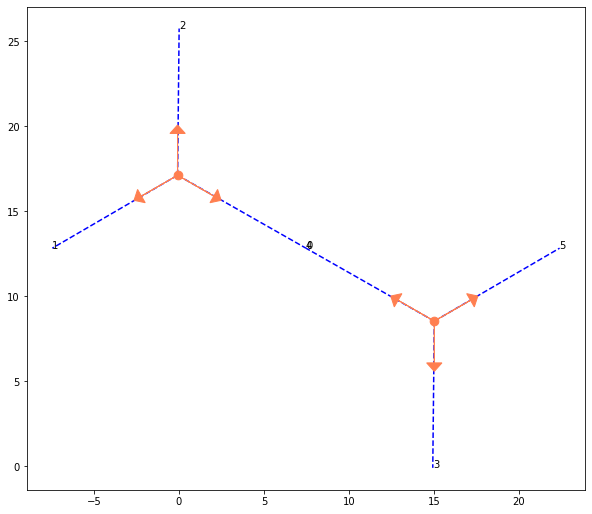

In [6]:
natoms = len(cg_atoms)
cell = cg_atoms.cell
positions = cg_atoms.positions
core_linker_dir = cg_atoms.get_array('linker_sites')
core_linker_neigh = cg_atoms.get_array('linker_neighbors')
bonds = _get_bonds(cg_atoms, r0)

nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
nl.update(cg_atoms)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(positions[:,0],positions[:,1], color='coral', marker='o', s=75, zorder=10)
for i in range(core_linker_dir.shape[0]):
    for li in range(core_linker_dir.shape[1]):
        ax.arrow(positions[i,0],positions[i,1], core_linker_dir[i,li,0], core_linker_dir[i,li,1], color='coral', head_width=0.9, head_length=0.5, zorder=10)

for ib,b in enumerate(bonds):
    ii, nii, jj, njj = b[0], b[1], b[2], b[3]

    # get angle for site ii
    neighbors, offsets = nl.get_neighbors(ii)
    cells = np.dot(offsets, cell)
    distance_vectors = positions[neighbors] + cells - positions[ii]

    v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
    v1 = distance_vectors[nii] # vector from ii to neighbor nii        
    
    ax.plot([positions[ii][0], positions[ii][0]+v1[0]/2], [positions[ii][1], positions[ii][1]+v1[1]/2], 'b--')
    ax.annotate(str(ib), [positions[ii][0]+v1[0]/2, positions[ii][1]+v1[1]/2])
        
plt.show()

In [7]:
core_descriptors, bond_descriptors = collect_descriptors(structures, cy, mfs, r0)

print('number of samples: %d' % (len(bond_descriptors)))
print('number of linkers: %d' % (len(bond_descriptors[0])))
print('number of descriptors per linker: %d' % (len(bond_descriptors[0][0])))
print('number of cores: %d' % (len(core_descriptors[0])))
print('number of descriptors per core: %d' % (len(core_descriptors[0][0])))

number of samples: 28
number of linkers: 6
number of descriptors per linker: 3
number of cores: 2
number of descriptors per core: 3


# Training using Ridge regression

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [9]:
# feature matrix
X = get_feature_matrix(core_descriptors, bond_descriptors)

# target values
y = energies-energies.min()

In [10]:
# this somehow does not work as I expect, see below
reg = RidgeCV(alphas=[1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]).fit(X, y)
reg.score(X, y)

0.3797486516367544

In [11]:
reg.alpha_

1e-12

In [12]:
reg = Ridge(alpha=1e-11).fit(X, y)
reg.score(X, y)

0.9999832983254922

In [13]:
mean_squared_error(reg.predict(X), y)

1.657784568295845e-07

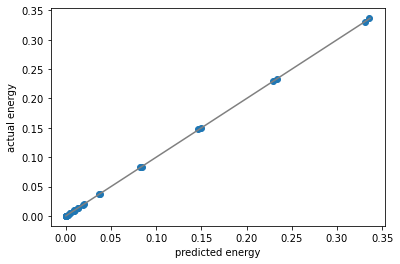

In [14]:
plt.scatter(reg.predict(X), y)
plt.plot([0., y.max()], [0., y.max()], color='grey')
plt.xlabel('predicted energy')
plt.ylabel('actual energy')
plt.show()

In [15]:
reg.coef_

array([-44.4342221 ,   1.27912546,   4.45880587,   4.45880586,
         4.45880373,  27.369685  ])

In [17]:
reg.intercept_

2315.3320266790165

# Prediction for defect structure

In [18]:
s0 = read('../test-data/COF-5_opt_SW.gen', index=-1)
remove_hatoms(s0)

cy = find_cycles(s0)

G_cy = cycle_graph(cy, s0.positions)

for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])
    
mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))

148
108
18


In [19]:
# we could also use collect_descriptors but for plotting some additional stuff is needed

r0 = 30.082756/np.sqrt(3)

core_descriptors = []
bond_descriptors = []

G_cy = cycle_graph(cy, s0.positions)

r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs]) # compute core centers
core_linker_dir = [[G_cy.nodes[m[ls]]['pos'].mean(axis=0)-G_cy.nodes[m['B']]['pos'].mean(axis=0) for ls in ['A', 'C', 'D']] for m in mfs]

cg_atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True) # create coarse-grained representation based on core centers
cg_atoms.new_array('linker_sites', np.array(core_linker_dir)) # add positions of linker sites relative to core center

_find_linker_neighbor(cg_atoms, r0)

bonds = _get_bonds(cg_atoms, r0)
bond_desc = _get_bond_descriptors(cg_atoms, r0, bonds)
bond_descriptors.append(bond_desc)

core_desc = _get_core_descriptors(cg_atoms, r0)
core_descriptors.append(core_desc)    

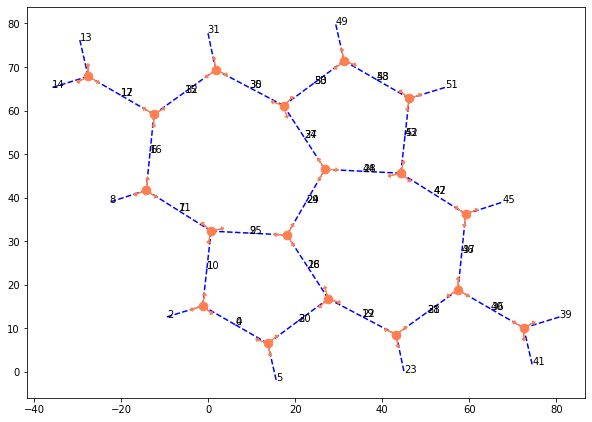

In [20]:
natoms = len(cg_atoms)
cell = cg_atoms.cell
positions = cg_atoms.positions
core_linker_dir = cg_atoms.get_array('linker_sites')
core_linker_neigh = cg_atoms.get_array('linker_neighbors')

nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
nl.update(cg_atoms)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(positions[:,0],positions[:,1], color='coral', marker='o', s=75, zorder=10)
for i in range(core_linker_dir.shape[0]):
    for li in range(core_linker_dir.shape[1]):
        ax.arrow(positions[i,0],positions[i,1], core_linker_dir[i,li,0], core_linker_dir[i,li,1], color='coral', head_width=0.9, head_length=0.5, zorder=10)

for ib,b in enumerate(bonds):
    ii, nii, jj, njj = b[0], b[1], b[2], b[3]

    # get angle for site ii
    neighbors, offsets = nl.get_neighbors(ii)
    cells = np.dot(offsets, cell)
    distance_vectors = positions[neighbors] + cells - positions[ii]

    v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
    v1 = distance_vectors[nii] # vector from ii to neighbor nii        
    
    ax.plot([positions[ii][0], positions[ii][0]+v1[0]/2], [positions[ii][1], positions[ii][1]+v1[1]/2], 'b--')
    ax.annotate(str(ib), [positions[ii][0]+v1[0]/2, positions[ii][1]+v1[1]/2])
        
plt.show()

In [21]:
# feature matrix
X = get_feature_matrix(core_descriptors, bond_descriptors)

print('number of samples: %d' % (len(bond_descriptors)))
print('number of linkers: %d' % (len(bond_descriptors[0])))
print('number of descriptors per linker: %d' % (len(bond_descriptors[0][0])))
print('number of cores: %d' % (len(core_descriptors[0])))
print('number of descriptors per core: %d' % (len(core_descriptors[0][0])))

number of samples: 1
number of linkers: 54
number of descriptors per linker: 3
number of cores: 18
number of descriptors per core: 3


In [22]:
reg.intercept_ = reg.intercept_ * 54/6 # we have to adjust the intercept for the different number of linkers!

In [23]:
# final energy
reg.predict(X)

array([12.75394945])

In [24]:
np.dot(reg.coef_, X.reshape(-1)) + reg.intercept_

12.753949449299398

# Calculator

In [25]:
from cgf.surrogate import MikadoRR

In [32]:
calc = MikadoRR(r0=30.082756/np.sqrt(3), rr_coeff=np.array([-44.4342221, 1.27912546, 4.45880587, 4.45880586,
         4.45880373, 27.369685]), rr_incpt=2315.3320266790165/6)

In [33]:
cg_atoms.calc = calc

In [34]:
cg_atoms.get_potential_energy()

12.753976338633947